In [81]:
# First, check and install package BiocManager if it has not been already installed
# This package enables installing Bioconductor packages
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")

In [82]:
# Install Bioconductor packages needed for this module
# Package GEOquery is used to download raw files from the GEO repository
if (!requireNamespace("GEOquery", quietly = TRUE)) BiocManager::install("GEOquery")
# Package minfi is used to read raw methylation data into R, and perform preprocessing steps
if(!requireNamespace("minfi", quietly=TRUE)) BiocManager::install("minfi")
# The chip (450k) manifest and annotation packages are needed to annotate probe identifiers with genomic features
if(!requireNamespace("IlluminaHumanMethylation450kmanifest", quietly=TRUE)) BiocManager::install("IlluminaHumanMethylation450kmanifest")
if(!requireNamespace("IlluminaHumanMethylation450kanno.ilmn12.hg19", quietly=TRUE)) BiocManager::install("IlluminaHumanMethylation450kanno.ilmn12.hg19")
# Package limma is used to perform a differential methylation test
if (!requireNamespace("limma", quietly = TRUE)) BiocManager::install("limma")

In [83]:
# Load the needed packages
library(GEOquery)
library(minfi)
library(IlluminaHumanMethylation450kmanifest)
library(IlluminaHumanMethylation450kanno.ilmn12.hg19)
library(limma)

In [15]:
# 1) Prepare files.
#    Use package GEOquery to download raw files of series GSE47915 from the GEO repository. 
#    This series has 4 prostate tumor samples and 4 benign samples. 
#    Raw data files will be downloaded as a compressed folder under a newly created folder carrying the name of the GEO series.

#    Object downloaded will be a data frame with rownames representing the full path of the resulting downloaded files. 
#    The records in this data frame represent information for each downloaded file
downloaded <- getGEOSuppFiles("GSE47915")

In [16]:
# Set the working directory to the newly created folder
setwd(paste(getwd(), "/GSE47915", sep=""))
# Decompress the download tar folder GSE47915_RAW.tar
untar("GSE47915_RAW.tar")
# Delete the downloaded compressed files since they are no longer needed
file.remove("GSE47915_RAW.tar")
file.remove("GSE47915_signal_intensities.txt.gz")

[1] TRUE

[1] TRUE

In [56]:
# There are 2 raw files (with .idat extension) per sample: One for the red channel and one for the green channel
# Create the base names for raw files
idat.files <- list.files(pattern="idat")
idat.basenames <- sub(x=idat.files, pattern="_Grn.idat.gz", replacement="")
idat.basenames <- sub(x=idat.basenames, pattern="_Red.idat.gz", replacement="")
idat.basenames <- unique(idat.basenames)
# Create group labels for samples
group.labels <- c("benign", "tumor", "tumor", "tumor", "tumor", "benign", "benign", "benign")
idat.basenames
group.labels

[1] "GSM1162363_6264509108_R01C02" "GSM1162364_6264509130_R04C02"
[3] "GSM1162365_6264509130_R03C02" "GSM1162369_6264509130_R06C01"
[5] "GSM1162375_6264509130_R05C01" "GSM1162380_6285609104_R03C02"
[7] "GSM1162381_6285650040_R06C02" "GSM1162382_6285650050_R01C01"

[1] "benign" "tumor"  "tumor"  "tumor"  "tumor"  "benign" "benign" "benign"

In [57]:
# 2) Read raw data.
#    Use package minfi to read raw idat files into R
#    Proper annotation and chip manafest packages are needed

#    Read raw files into one RGChannelSet data object
RGset <- read.metharray(basenames=idat.basenames)
RGset

Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string 

class: RGChannelSet 
dim: 622399 8 
metadata(0):
assays(2): Green Red
rownames(622399): 10600313 10600322 ... 74810490 74810492
rowData names(0):
colnames(8): GSM1162363_6264509108_R01C02 GSM1162364_6264509130_R04C02
  ... GSM1162381_6285650040_R06C02 GSM1162382_6285650050_R01C01
colData names(0):
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19

In [58]:
# 3) preprocess raw data:
#    Identify probes with poor quality (detection p-value >0.01) based on detection p-values
detP <- detectionP(RGset, type = "m+u")
poorProbes <- which(rowSums(detP > 0.01) > 0)
#    remove probes with poor quality
RGset <- RGset[-poorProbes,]
#    Preprocess raw intensities using the Illumina Genome Analyzer method (one option among others)
Mset <- preprocessIllumina(RGset)
Mset
#    Annotate probes in the methylation set data object
GMset <- mapToGenome(Mset)
GMset
#    Calculate the methylation metric (Beta values) from the methylated and unmethylated probe values
rc <- ratioConvert(GMset)
rc

class: MethylSet 
dim: 483896 8 
metadata(0):
assays(2): Meth Unmeth
rownames(483896): cg00050873 cg00212031 ... ch.22.47579720R
  ch.22.48274842R
rowData names(0):
colnames(8): GSM1162363_6264509108_R01C02 GSM1162364_6264509130_R04C02
  ... GSM1162381_6285650040_R06C02 GSM1162382_6285650050_R01C01
colData names(0):
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19
Preprocessing
  Method: Illumina, bg.correct = TRUE, normalize = controls, reference = 1
  minfi version: 1.40.0
  Manifest version: 0.4.0

class: GenomicMethylSet 
dim: 483896 8 
metadata(0):
assays(2): Meth Unmeth
rownames(483896): cg13869341 cg14008030 ... cg08265308 cg14273923
rowData names(0):
colnames(8): GSM1162363_6264509108_R01C02 GSM1162364_6264509130_R04C02
  ... GSM1162381_6285650040_R06C02 GSM1162382_6285650050_R01C01
colData names(0):
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19
Preprocessing
  Method: Illumina, bg.correct = TRUE, normalize = controls, reference = 1
  minfi version: 1.40.0
  Manifest version: 0.4.0

class: GenomicRatioSet 
dim: 483896 8 
metadata(0):
assays(2): Beta CN
rownames(483896): cg13869341 cg14008030 ... cg08265308 cg14273923
rowData names(0):
colnames(8): GSM1162363_6264509108_R01C02 GSM1162364_6264509130_R04C02
  ... GSM1162381_6285650040_R06C02 GSM1162382_6285650050_R01C01
colData names(0):
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19
Preprocessing
  Method: Illumina, bg.correct = TRUE, normalize = controls, reference = 1
  minfi version: 1.40.0
  Manifest version: 0.4.0

In [59]:
# 4) Remove additional probes.
#    Remove CpG probes at genomic locations overlapping known SNPs with non-zero allele frequency.
#    Checking the methylation status at locations with known SNPs is not useful.
rc <- addSnpInfo(rc)
rc <- dropLociWithSnps(rc, snps=c("SBE","CpG"), maf=0)

In [60]:
# 5) Annotate probe sites
#    Get all available annotation information for probe sites
rc.ann <- getAnnotation(object=rc, what="everything", lociNames=NULL, orderByLocation=FALSE, dropNonMapping=TRUE)
#    There are too many columns in the Table but not all this information is needed
colnames(rc.ann)
#    Keep only UCSC genic region annotations
rc.ann.short <- rc.ann[,c("chr","pos","strand","UCSC_RefGene_Name","UCSC_RefGene_Group")]
head(rc.ann.short, n=6)

[1] "chr"                      "pos"                     
 [3] "strand"                   "Name"                    
 [5] "AddressA"                 "AddressB"                
 [7] "ProbeSeqA"                "ProbeSeqB"               
 [9] "Type"                     "NextBase"                
[11] "Color"                    "Probe_rs"                
[13] "Probe_maf"                "CpG_rs"                  
[15] "CpG_maf"                  "SBE_rs"                  
[17] "SBE_maf"                  "Islands_Name"            
[19] "Relation_to_Island"       "Forward_Sequence"        
[21] "SourceSeq"                "Random_Loci"             
[23] "Methyl27_Loci"            "UCSC_RefGene_Name"       
[25] "UCSC_RefGene_Accession"   "UCSC_RefGene_Group"      
[27] "Phantom"                  "DMR"                     
[29] "Enhancer"                 "HMM_Island"              
[31] "Regulatory_Feature_Name"  "Regulatory_Feature_Group"
[33] "DHS"

DataFrame with 6 rows and 5 columns
                   chr       pos      strand UCSC_RefGene_Name
           <character> <integer> <character>       <character>
cg13869341        chr1     15865           +            WASH5P
cg14008030        chr1     18827           +            WASH5P
cg12045430        chr1     29407           +            WASH5P
cg20826792        chr1     29425           +            WASH5P
cg00381604        chr1     29435           +            WASH5P
cg20253340        chr1     68849           +             OR4F5
           UCSC_RefGene_Group
                  <character>
cg13869341               Body
cg14008030               Body
cg12045430             TSS200
cg20826792             TSS200
cg00381604             TSS200
cg20253340            TSS1500

In [61]:
# 6) Perform differential methylation (DM) analysis using package limma
#    Get probe-level methylation ratio values (Beta)
probeBeta <- getBeta(rc)
design <- model.matrix(~group.labels)
fit <- lmFit(log2(1+probeBeta), design=design)
fit <- eBayes(fit)
limma.results <- topTable(fit, n=nrow(fit))
head(limma.results, n=6)

Warning message:
"Zero sample variances detected, have been offset away from zero"
Removing intercept from test coefficients



,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cg16794576,0.6966775,0.3914830,54.81206,7.020823e-11,3.274526e-05,11.28386
cg20527270,0.7017513,0.4169308,47.85707,1.900248e-10,4.431397e-05,11.04865
cg23511432,0.6425535,0.3352367,43.54659,3.796747e-10,5.085583e-05,10.85362
cg19670286,0.5564508,0.2916982,41.65459,5.257900e-10,5.085583e-05,10.75206
cg14855334,0.5158862,0.2863200,40.95672,5.950915e-10,5.085583e-05,10.71171
cg24578679,0.4986884,0.2734214,40.43053,6.542318e-10,5.085583e-05,10.68018


In [76]:
# 7) Extract an annotated results Table of significant probes only and save it
#    Probes with significant DM are those that meet assigned thresholds (small adjusted p-value and large absolute fold-change) 
sig <- which((limma.results$adj.P.Val < 0.001) & (abs(limma.results$logFC) > 0.4))
print(paste("There are ", length(sig), " significant probes", sep=""), quote=FALSE)
#    Extract significant probes from the limma results Table and add probe annotations
limma.sig.ann <- cbind(limma.results[sig,], rc.ann.short[rownames(limma.results[sig,]),])
#    Create a dataframe object and save results as a csv file 
df <- as.data.frame(limma.sig.ann)
write.csv(df, file="limma_significant_probes.csv")
head(df, n=4)

[1] There are 439 significant probes


,logFC,AveExpr,t,P.Value,adj.P.Val,B,chr,pos,strand,UCSC_RefGene_Name,UCSC_RefGene_Group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>
cg16794576,0.6966775,0.3914830,54.81206,7.020823e-11,3.274526e-05,11.28386,chr6,29974971,+,HLA-J;NCRNA00171,Body;Body
cg20527270,0.7017513,0.4169308,47.85707,1.900248e-10,4.431397e-05,11.04865,chr8,49468688,-,,
cg23511432,0.6425535,0.3352367,43.54659,3.796747e-10,5.085583e-05,10.85362,chr5,137610255,+,GFRA3,TSS200
cg19670286,0.5564508,0.2916982,41.65459,5.257900e-10,5.085583e-05,10.75206,chr5,137610127,-,GFRA3;GFRA3,1stExon;5'UTR


In [77]:
# 8) Find significant probes within 200 base pairs upstream from transcription start sites (TSS) of genes according to the used annotations
TSS200.probes <- df[grep("TSS200", df[, "UCSC_RefGene_Group"]),]
#    Identify one gene with most significant probes within 200 base pairs upstream from its TSS
names(which.max(table(TSS200.probes$UCSC_RefGene_Name)))
#    Find how many significant probes overlapping the previous gene's TSS200 region
max(table(TSS200.probes$UCSC_RefGene_Name))
#    Show DM probes overlapping the APC gene
APC.DM <- df[grep("APC", df$UCSC_RefGene_Name),]
APC.DM
#    Show DM probes overlapping the TSS200 region of the APC gene
APC.DM[grep("TSS200", APC.DM$UCSC_RefGene_Group),]

[1] "APC;APC;APC"

[1] 8

,logFC,AveExpr,t,P.Value,adj.P.Val,B,chr,pos,strand,UCSC_RefGene_Name,UCSC_RefGene_Group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>
cg00577935,0.5562143,0.3205442,25.73945,1.774322e-08,0.0001880790,9.187919,chr5,112073348,-,APC;APC;APC,TSS1500;5'UTR;TSS1500
cg03667968,0.7250064,0.3843661,23.62244,3.313637e-08,0.0002121341,8.813446,chr5,112073438,-,APC;APC;APC,TSS200;TSS200;5'UTR
cg08571859,0.5895476,0.3478463,23.33792,3.618781e-08,0.0002143392,8.758239,chr5,112073350,-,APC;APC;APC,TSS1500;5'UTR;TSS1500
cg21634602,0.6140667,0.4128732,20.13080,1.057595e-07,0.0003300325,8.039612,chr5,112073570,-,APC;APC;APC;APC;APC,1stExon;5'UTR;1stExon;5'UTR;5'UTR
cg22035501,0.6767323,0.3780227,19.87750,1.159102e-07,0.0003427294,7.974298,chr5,112073398,-,APC;APC;APC,TSS200;TSS200;5'UTR
cg20311501,0.5778933,0.4592795,19.55280,1.305767e-07,0.0003584432,7.888495,chr5,112073502,-,APC;APC;APC,TSS200;TSS200;5'UTR
cg16970232,0.6217628,0.3990060,18.85171,1.700141e-07,0.0004014452,7.694880,chr5,112073433,-,APC;APC;APC,TSS200;TSS200;5'UTR
cg23938220,0.5957299,0.3266027,18.64825,1.838730e-07,0.0004014452,7.636461,chr5,112073538,+,APC;APC;APC,TSS200;TSS200;5'UTR
cg14479889,0.6267209,0.3733991,18.54142,1.916598e-07,0.0004044819,7.605370,chr5,112073426,-,APC;APC;APC,TSS200;TSS200;5'UTR


,logFC,AveExpr,t,P.Value,adj.P.Val,B,chr,pos,strand,UCSC_RefGene_Name,UCSC_RefGene_Group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>
cg03667968,0.7250064,0.3843661,23.62244,3.313637e-08,0.0002121341,8.813446,chr5,112073438,-,APC;APC;APC,TSS200;TSS200;5'UTR
cg22035501,0.6767323,0.3780227,19.87750,1.159102e-07,0.0003427294,7.974298,chr5,112073398,-,APC;APC;APC,TSS200;TSS200;5'UTR
cg20311501,0.5778933,0.4592795,19.55280,1.305767e-07,0.0003584432,7.888495,chr5,112073502,-,APC;APC;APC,TSS200;TSS200;5'UTR
cg16970232,0.6217628,0.3990060,18.85171,1.700141e-07,0.0004014452,7.694880,chr5,112073433,-,APC;APC;APC,TSS200;TSS200;5'UTR
cg23938220,0.5957299,0.3266027,18.64825,1.838730e-07,0.0004014452,7.636461,chr5,112073538,+,APC;APC;APC,TSS200;TSS200;5'UTR
cg14479889,0.6267209,0.3733991,18.54142,1.916598e-07,0.0004044819,7.605370,chr5,112073426,-,APC;APC;APC,TSS200;TSS200;5'UTR
cg14511739,0.6323725,0.3837386,16.25636,4.940293e-07,0.0006545917,6.864611,chr5,112073373,-,APC;APC;APC,TSS200;TSS200;5'UTR
cg02511809,0.5541877,0.4328240,16.04170,5.434749e-07,0.0006887983,6.786821,chr5,112073544,+,APC;APC;APC,TSS200;TSS200;5'UTR


**Note:** Gene APC is known to be hypermethylated in prostate cancer [*] There are 8 significant DM probes within 200 base pairs from the TSS of gene APC.

*Chen Y, Li J, Yu X, Li S, Zhang X, Mo Z, Hu Y. APC gene hypermethylation and prostate cancer: a systematic review and meta-analysis. Eur J Hum Genet. 2013; 21(9):929-35.

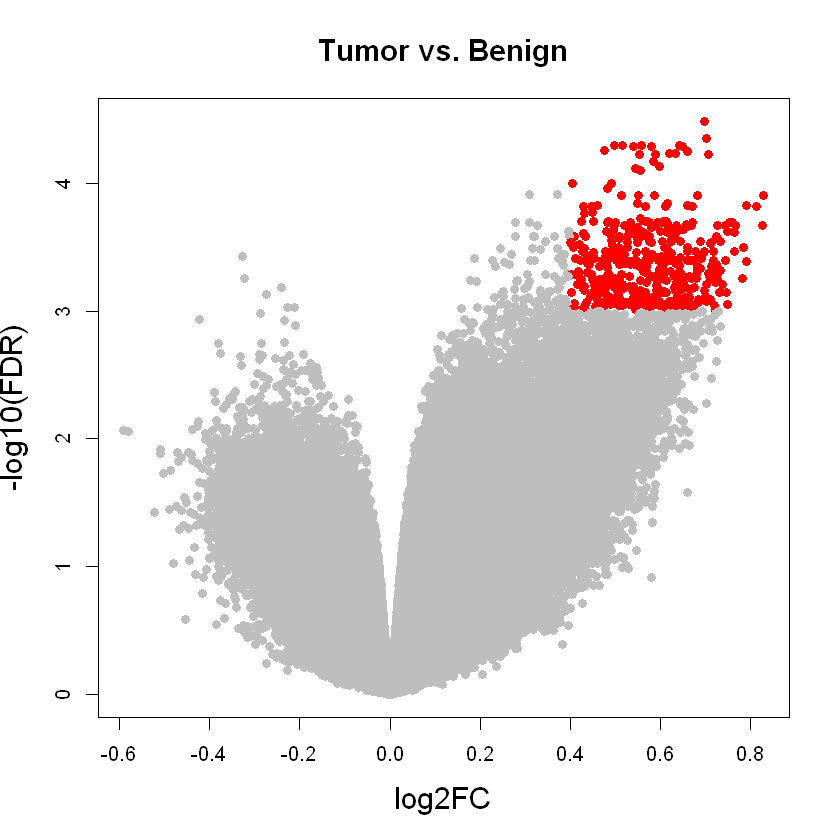

In [78]:
# 9) Results visualization.
#    Create a volcano plot to highlight significant probes
color <- rep("gray", nrow(limma.results))
#    highlight DM probes with red color
color[sig] <- "red"
plot(limma.results$logFC, -log10(limma.results$adj.P.Val), type="p", cex.lab=1.5, cex.main=1.5,
pch=16, col=color, xlab="log2FC", ylab="-log10(FDR)", main="Tumor vs. Benign")

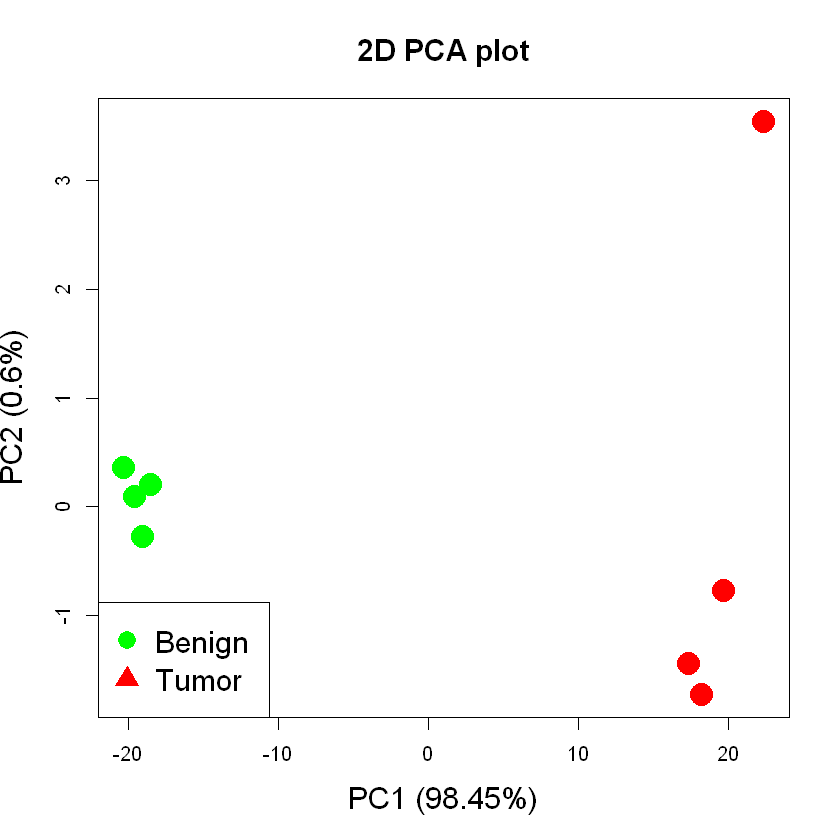

In [79]:
# 10) Generate PCA plot using only DM probes
pca <- prcomp(t(log2(1+probeBeta)[rownames(limma.results[sig,]),]), scale=T)
a <- pca$sdev
pc1 <- a[1]^2/sum(a^2)
pc2 <- a[2]^2/sum(a^2)
colors <- ifelse(group.labels=="benign", "green", "red")
plot(pca$x[,1:2], pch=ifelse(group.labels=="benign", 16, 17), cex=2.5, cex.lab=1.5, cex.main=1.5, col=colors, main="2D PCA plot",
xlab=paste("PC1 (", round(100*pc1, 2), "%)", sep=""), 
ylab=paste("PC2 (", round(100*pc2, 2), "%)", sep=""))
legend("bottomleft", legend=c("Benign","Tumor"), col=c("green","red"), pch=c(16,17), cex=1.5, pt.cex=2)

**Conclusion:** PCA scatter plot using the methylation profiles of probes that showed significant DM shows excellent clustering of tumor and normal samples into two distinct groups as expected whe nusing only highly discriminative features between groups. Additional functional analysis of the genes that top significant probes overlap could be performed to explore for meaningful biological interpretations.

In [80]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19045)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] limma_3.50.3                                      
 [2] IlluminaHumanMethylation450kanno.ilmn12.hg19_0.6.0
 [3] IlluminaHumanMethylation450kmanifest_0.4.0        
 [4] minfi_1.40.0                                      
 [5] bumphunter_1.36.0                                 
 [6] locfit_1.5-9.6                                    
 [7] iterators_1.0.14                                  
 [8] foreach_1.5.2                                     
 [9] Biostrings_2.62.0                